# Generative Modeling exercises

In the first part of this notebook, we are doing the following:

1.   Clone the Git repository with the pretrained models
2.   Load necessary libraries
3.   Set up training loop
4.   Define generator and critic
5.   Train GAN
6.   Access generator performance

All the code is already written. Due to the long training times all models are pretrained. You simply have to load them. 

Then aim of the notebook is for you to get familiar with the the whole training setup in PyTorch and analyze the quality of the generated data.

Furthermore, we recommend that you think about it can be applied/adjusted to your own research. We highly recommend asking questions in this regard.

Note that the neural network classes and the training loop can be written in many different ways! This is just one way of doing it.


In [1]:
# Load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import pdb
import numpy as np
import imageio
from google.colab import drive
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
drive.mount('/content/gdrive',force_remount=True)
path = 'gdrive/MyDrive/Colab Notebooks/masterclass'
os.chdir(path)

Mounted at /content/gdrive


In [11]:
!git clone https://github.com/nmucke/computational_imaging_masterclass.git

fatal: destination path 'computational_imaging_masterclass' already exists and is not an empty directory.


In [4]:
# Load MNIST training data
bs = 256

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), 
                         std=(0.5))
    ])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [5]:
# Train Wasserstein GAN

class TrainGAN():
    def __init__(self, generator, critic, generator_optimizer, critic_optimizer,
                 latent_dim=100, n_critic=5, gamma=10, device='cpu',
                 wasserstein=True):

        self.to_pil_image = transforms.ToPILImage()

        self.device = device
        self.generator = generator
        self.critic = critic
        self.G_opt = generator_optimizer
        self.C_opt = critic_optimizer

        self.generator.train()
        self.critic.train()

        self.latent_dim = latent_dim
        self.n_critic = n_critic
        self.gamma = gamma
        self.steps = 0
        self.fixed_z = torch.randn(64, self.latent_dim).to(self.device)

        self.wasserstein = wasserstein
        if not self.wasserstein:
          self.bce_loss = nn.BCELoss()

    def train(self, data_loader, n_epochs):
        """Train generator and critic"""

        images = []
        generator_loss = []
        critic_loss = []
        gradient_penalty = []
        for epoch in range(1, n_epochs + 1):

            # Train one step
            g_loss, c_loss, grad_penalty = self.train_epoch(data_loader)

            print(f'Epoch: {epoch}, g_loss: {g_loss:.3f},', end=' ')
            if self.wasserstein:
              print(f'c_loss: {c_loss:.3f}, grad_penalty: {grad_penalty:.3f}')
            else:
              print(f'c_loss: {c_loss:.3f}')

            # Save loss
            generator_loss.append(g_loss)
            critic_loss.append(c_loss)
            gradient_penalty.append(grad_penalty)

            # Save generated images
            generated_img = self.generator(self.fixed_z)
            generated_img = make_grid(generated_img)
            images.append(generated_img)
            self.save_generator_image(generated_img,f"outputs_WGAN/gen_img{epoch}_latent_{self.latent_dim}.png")
        
        # save the generated images as GIF file
        imgs = [np.array(self.to_pil_image(img)) for img in images]
        imageio.mimsave(f'outputs_WGAN/generator_images_latent_{self.latent_dim}.gif', imgs)

        if self.wasserstein:
          # save the generated images as GIF file
          imgs = [np.array(self.to_pil_image(img)) for img in images]
          imageio.mimsave(f'outputs_WGAN/W_generator_images_latent_{self.latent_dim}.gif', imgs)

          # Save generator and critic weights
          torch.save(self.generator.state_dict(), f'model_weights/W_generator_latent_{self.latent_dim}')
          torch.save(self.critic.state_dict(), f'model_weights/W_critic_latent_{self.latent_dim}')
        else:
          # save the generated images as GIF file
          imgs = [np.array(self.to_pil_image(img)) for img in images]
          imageio.mimsave(f'outputs_WGAN/generator_images_latent_{self.latent_dim}.gif', imgs)

          # Save generator and critic weights
          torch.save(self.generator.state_dict(), f'model_weights/generator_latent_{self.latent_dim}')
          torch.save(self.critic.state_dict(), f'model_weights/critic_latent_{self.latent_dim}')
        

        self.generator.train(mode=False)
        self.critic.train(mode=False)

        return generator_loss, critic_loss, gradient_penalty

    def train_epoch(self, data_loader):
        """Train generator and critic for one epoch"""

        for bidx, (real_data, _) in  tqdm(enumerate(data_loader),
                 total=int(len(data_loader.dataset)/data_loader.batch_size)):

            current_batch_size = len(real_data)

            real_data = real_data.to(self.device)

            c_loss, grad_penalty = self.critic_train_step(real_data)

            if bidx % self.n_critic == 0:
              g_loss = self.generator_train_step(current_batch_size)

        return g_loss, c_loss, grad_penalty

    def critic_train_step(self, data):
        """Train critic one step"""

        batch_size = data.size(0)
        generated_data = self.sample(batch_size)


        if self.wasserstein:
          grad_penalty = self.gradient_penalty(data, generated_data)
          c_loss = self.critic(generated_data).mean() - self.critic(data).mean() + grad_penalty
          grad_penalty = grad_penalty.item()
        else:
          label = torch.ones((batch_size, 1), device=self.device)
          c_loss = self.bce_loss(self.critic(data), label)

          label = torch.zeros((batch_size, 1), device=self.device)
          c_loss += self.bce_loss(self.critic(generated_data), label)

          grad_penalty = None

        self.C_opt.zero_grad()
        c_loss.backward()
        self.C_opt.step()
        
        return c_loss.item(), grad_penalty

    def generator_train_step(self, batch_size):
        """Train generator one step"""

        self.G_opt.zero_grad()
        generated_data = self.sample(batch_size)


        if self.wasserstein:
          g_loss = -self.critic(generated_data).mean()
        else:
          label = torch.ones((batch_size, 1), device=self.device)
          g_loss = self.bce_loss(self.critic(generated_data), label)

        g_loss.backward()
        self.G_opt.step()

        return g_loss.item()

    def gradient_penalty(self, data, generated_data, gamma=10):
        """Compute gradient penalty"""

        batch_size = data.size(0)
        epsilon = torch.rand(batch_size, 1, 1, 1)
        epsilon = epsilon.expand_as(data).to(self.device)

        interpolation = epsilon * data.data + (1 - epsilon) * generated_data
        interpolation = torch.autograd.Variable(interpolation, requires_grad=True)
        interpolation = interpolation.to(self.device)

        interpolation_critic_score = self.critic(interpolation)

        grad_outputs = torch.ones(interpolation_critic_score.size())
        grad_outputs = grad_outputs.to(self.device)

        gradients = torch.autograd.grad(outputs=interpolation_critic_score,
                                        inputs=interpolation,
                                        grad_outputs=grad_outputs,
                                        create_graph=True,
                                        retain_graph=None)[0]

        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return self.gamma * ((gradients_norm - 1) ** 2).mean()

    def sample(self, n_samples):
        """Generate n_samples fake samples"""

        z = torch.randn(n_samples, self.latent_dim).to(self.device)
        return self.generator(z)

    def save_generator_image(self, image, path):
        """Save image"""

        save_image(image, path)

In [6]:
# Define generator
class Generator(nn.Module):
  def __init__(self, latent_dim, num_out_channels=1):
    super(Generator, self).__init__()
    self.activation = nn.LeakyReLU()
    self.latent_dim = latent_dim

    hidden_channels = [256, 128, 64, 32]
    self.hidden_channels = hidden_channels

    self.fc = nn.Linear(latent_dim, hidden_channels[0]*7*7)
    self.trans_conv1 = nn.ConvTranspose2d(
        hidden_channels[0], hidden_channels[1], kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    self.trans_conv1_bn = nn.BatchNorm2d(hidden_channels[1])
    self.trans_conv2 = nn.ConvTranspose2d(
        hidden_channels[1], hidden_channels[2], kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv2_bn = nn.BatchNorm2d(hidden_channels[2])
    self.trans_conv3 = nn.ConvTranspose2d(
        hidden_channels[2], hidden_channels[3], kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv3_bn = nn.BatchNorm2d(hidden_channels[3])
    self.trans_conv4 = nn.ConvTranspose2d(
        hidden_channels[3], num_out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias=False)

  # forward method
  def forward(self, x): 
    x = self.fc(x)
    x = self.activation(x)
    x = x.view(-1, self.hidden_channels[0], 7, 7)
    x = self.trans_conv1(x)
    x = self.activation(x)
    x = self.trans_conv1_bn(x)
    x = self.trans_conv2(x)
    x = self.activation(x)
    x = self.trans_conv2_bn(x)
    x = self.trans_conv3(x)
    x = self.activation(x)
    x = self.trans_conv3_bn(x)
    x = self.trans_conv4(x)
    return x

# Define critic
class Critic(nn.Module):
  def __init__(self, num_in_channels=1, wasserstein=True):
    super(Critic, self).__init__()
    self.activation = nn.LeakyReLU()

    self.wasserstein = wasserstein
    if not self.wasserstein:
      self.sigmoid = nn.Sigmoid()

    hidden_channels = [32, 64, 128, 256]

    self.conv0 = nn.Conv2d(num_in_channels, hidden_channels[0], kernel_size = 3, stride = 2, padding = 1)
    self.conv1 = nn.Conv2d(hidden_channels[0], hidden_channels[1], kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(hidden_channels[1], hidden_channels[2], kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(hidden_channels[2], hidden_channels[3], kernel_size = 3, stride = 2, padding = 1)
    self.fc = nn.Linear(12544, 1, bias=False)
    
    # forward method
  def forward(self, x):
    x = self.conv0(x)
    x = self.activation(x)
    x = self.conv1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.activation(x)
    x = self.conv3(x)
    x = self.activation(x)

    x = x.view(-1, 12544)
    x = self.fc(x)

    if self.wasserstein:
      return x
    else:
      return self.sigmoid(x)


In [ ]:

# build network
latent_dim = 2
wasserstein = True
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
critic = Critic(num_in_channels=1, wasserstein=wasserstein).to(device)

# optimizer
lr = 0.0002 
generator_optimizer = optim.RMSprop(generator.parameters(), lr = lr)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = lr)

# Trainer
training_params = {
    'generator': generator,
    'critic': critic,
    'generator_optimizer': generator_optimizer, 
    'critic_optimizer': critic_optimizer,
    'latent_dim': latent_dim, 
    'n_critic': 1, 
    'gamma': 10, 
    'device': device,
    'wasserstein': wasserstein
}

trainer = TrainGAN(**training_params)

trainer.train(
  data_loader=train_loader,
  n_epochs=100
  )

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
235it [00:43,  5.36it/s]                         


Epoch: 1, g_loss: 0.823, c_loss: -9.654, grad_penalty: 1.301


235it [00:43,  5.45it/s]                         


Epoch: 2, g_loss: 3.017, c_loss: -4.249, grad_penalty: 0.124


235it [00:43,  5.45it/s]                         


Epoch: 3, g_loss: 10.682, c_loss: -4.392, grad_penalty: 0.596


235it [00:43,  5.45it/s]                         


Epoch: 4, g_loss: 4.990, c_loss: -4.289, grad_penalty: 0.364


235it [00:43,  5.44it/s]                         


Epoch: 5, g_loss: 6.729, c_loss: -4.308, grad_penalty: 0.503


235it [00:45,  5.17it/s]                         


Epoch: 6, g_loss: 5.483, c_loss: -4.049, grad_penalty: 0.343


235it [00:43,  5.44it/s]                         


Epoch: 7, g_loss: -0.880, c_loss: -4.040, grad_penalty: 0.233


235it [00:43,  5.38it/s]                         


Epoch: 8, g_loss: -2.999, c_loss: -3.694, grad_penalty: 0.252


235it [00:42,  5.47it/s]                         


Epoch: 9, g_loss: 1.309, c_loss: -3.925, grad_penalty: 0.222


235it [00:43,  5.46it/s]                         


Epoch: 10, g_loss: -0.023, c_loss: -3.512, grad_penalty: 0.296


235it [00:43,  5.45it/s]                         


Epoch: 11, g_loss: 2.267, c_loss: -3.288, grad_penalty: 0.271


235it [00:43,  5.46it/s]                         


Epoch: 12, g_loss: 6.697, c_loss: -2.920, grad_penalty: 0.478


235it [00:43,  5.46it/s]                         


Epoch: 13, g_loss: 4.372, c_loss: -3.063, grad_penalty: 0.312


235it [00:43,  5.45it/s]                         


Epoch: 14, g_loss: 2.898, c_loss: -3.591, grad_penalty: 0.386


235it [00:42,  5.47it/s]                         


Epoch: 15, g_loss: 7.023, c_loss: -3.018, grad_penalty: 0.286


235it [00:42,  5.47it/s]                         


Epoch: 16, g_loss: 6.206, c_loss: -3.075, grad_penalty: 0.235


235it [00:43,  5.45it/s]                         


Epoch: 17, g_loss: 8.468, c_loss: -3.132, grad_penalty: 0.232


235it [00:43,  5.46it/s]                         


Epoch: 18, g_loss: 9.812, c_loss: -3.214, grad_penalty: 0.350


235it [00:43,  5.46it/s]                         


Epoch: 19, g_loss: 4.327, c_loss: -3.048, grad_penalty: 0.266


235it [00:43,  5.46it/s]                         


Epoch: 20, g_loss: 3.787, c_loss: -2.943, grad_penalty: 0.194


235it [00:42,  5.47it/s]                         


Epoch: 21, g_loss: 5.771, c_loss: -3.022, grad_penalty: 0.191


235it [00:42,  5.47it/s]                         


Epoch: 22, g_loss: 9.258, c_loss: -3.126, grad_penalty: 0.253


235it [00:43,  5.45it/s]                         


Epoch: 23, g_loss: 9.069, c_loss: -2.836, grad_penalty: 0.272


235it [00:43,  5.45it/s]                         


Epoch: 24, g_loss: 10.961, c_loss: -2.912, grad_penalty: 0.232


235it [00:42,  5.47it/s]                         


Epoch: 25, g_loss: 9.973, c_loss: -3.075, grad_penalty: 0.225


235it [00:43,  5.46it/s]                         


Epoch: 26, g_loss: 9.932, c_loss: -3.063, grad_penalty: 0.199


235it [00:43,  5.46it/s]                         


Epoch: 27, g_loss: 10.155, c_loss: -2.939, grad_penalty: 0.207


235it [00:43,  5.45it/s]                         


Epoch: 28, g_loss: 15.977, c_loss: -2.737, grad_penalty: 0.260


235it [00:43,  5.46it/s]                         


Epoch: 29, g_loss: 14.189, c_loss: -2.751, grad_penalty: 0.195


235it [00:42,  5.47it/s]                         


Epoch: 30, g_loss: 12.146, c_loss: -2.847, grad_penalty: 0.219


235it [00:43,  5.46it/s]                         


Epoch: 31, g_loss: 14.388, c_loss: -2.641, grad_penalty: 0.141


235it [00:42,  5.48it/s]                         


Epoch: 32, g_loss: 13.220, c_loss: -2.867, grad_penalty: 0.172


235it [00:42,  5.49it/s]                         


Epoch: 33, g_loss: 17.884, c_loss: -2.716, grad_penalty: 0.311


235it [00:42,  5.48it/s]                         


Epoch: 34, g_loss: 14.734, c_loss: -2.746, grad_penalty: 0.197


235it [00:42,  5.47it/s]                         


Epoch: 35, g_loss: 12.770, c_loss: -2.642, grad_penalty: 0.214


235it [00:42,  5.48it/s]                         


Epoch: 36, g_loss: 17.456, c_loss: -2.643, grad_penalty: 0.315


235it [00:42,  5.48it/s]                         


Epoch: 37, g_loss: 17.292, c_loss: -2.482, grad_penalty: 0.157


235it [00:42,  5.50it/s]                         


Epoch: 38, g_loss: 16.290, c_loss: -2.467, grad_penalty: 0.260


235it [00:42,  5.49it/s]                         


Epoch: 39, g_loss: 17.296, c_loss: -2.591, grad_penalty: 0.143


235it [00:42,  5.48it/s]                         


Epoch: 40, g_loss: 18.402, c_loss: -3.075, grad_penalty: 0.262


235it [00:42,  5.47it/s]                         


Epoch: 41, g_loss: 17.013, c_loss: -2.809, grad_penalty: 0.164


235it [00:43,  5.46it/s]                         


Epoch: 42, g_loss: 17.068, c_loss: -2.111, grad_penalty: 0.153


235it [00:42,  5.47it/s]                         


Epoch: 43, g_loss: 15.053, c_loss: -2.302, grad_penalty: 0.201


235it [00:43,  5.46it/s]                         


Epoch: 44, g_loss: 16.277, c_loss: -2.499, grad_penalty: 0.165


235it [00:42,  5.48it/s]                         


Epoch: 45, g_loss: 17.274, c_loss: -2.214, grad_penalty: 0.194


235it [00:42,  5.50it/s]                         


Epoch: 46, g_loss: 16.280, c_loss: -2.343, grad_penalty: 0.180


235it [00:43,  5.45it/s]                         


Epoch: 47, g_loss: 17.020, c_loss: -1.795, grad_penalty: 0.154


235it [00:43,  5.46it/s]                         


Epoch: 48, g_loss: 17.536, c_loss: -2.039, grad_penalty: 0.185


235it [00:43,  5.45it/s]                         


Epoch: 49, g_loss: 17.988, c_loss: -2.346, grad_penalty: 0.214


235it [00:43,  5.46it/s]                         


Epoch: 50, g_loss: 18.241, c_loss: -2.455, grad_penalty: 0.169


235it [00:43,  5.45it/s]                         


Epoch: 51, g_loss: 19.092, c_loss: -2.614, grad_penalty: 0.181


235it [00:43,  5.45it/s]                         


Epoch: 52, g_loss: 17.610, c_loss: -2.308, grad_penalty: 0.160


235it [00:44,  5.27it/s]                         


Epoch: 53, g_loss: 21.712, c_loss: -2.716, grad_penalty: 0.103


235it [00:43,  5.43it/s]                         


Epoch: 54, g_loss: 22.121, c_loss: -2.062, grad_penalty: 0.209


235it [00:43,  5.44it/s]                         


Epoch: 55, g_loss: 20.357, c_loss: -2.321, grad_penalty: 0.203


235it [00:43,  5.45it/s]                         


Epoch: 56, g_loss: 22.082, c_loss: -2.103, grad_penalty: 0.263


 98%|█████████▊| 229/234 [00:42<00:00,  5.33it/s]

In [9]:

latent_dim = 10
vanilla_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
wasserstein_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)

vanilla_state_dict_path = f'computational_imaging_masterclass/generator_latent_{latent_dim}'
vanilla_generator.load_state_dict(torch.load(vanilla_state_dict_path))

wasserstein_state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
wasserstein_generator.load_state_dict(torch.load(wasserstein_state_dict_path))

n_samples = 64
z = torch.randn(n_samples, latent_dim).to(device)

vanilla_generated_img = generator(z)
vanilla_generated_img = make_grid(vanilla_generated_img)[0:1]
vanilla_generated_img = vanilla_generated_img.detach().cpu().numpy()

wasserstein_generated_img = generator(z)
wasserstein_generated_img = make_grid(wasserstein_generated_img)[0:1]
wasserstein_generated_img = wasserstein_generated_img.detach().cpu().numpy()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(vanilla_generated_img[0])
plt.title('Vanilla GAN')
plt.subplot(1,2,2)
plt.imshow(wasserstein_generated_img[0])
plt.title('Wasserstein GAN')
plt.show()


FileNotFoundError: ignored

In [ ]:

latent_dim = 100

vanilla_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
wasserstein_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)

vanilla_state_dict_path = f'computational_imaging_masterclass/generator_latent_{latent_dim}'
generator.load_state_dict(torch.load(vanilla_state_dict_path))

wasserstein_state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
generator.load_state_dict(torch.load(wasserstein_state_dict_path))

z_lim = torch.linspace(-3, 3, 15)
z_x, z_y = torch.meshgrid(z_lim, z_lim)
z_x, z_y = z_x.flatten(), z_y.flatten()
z = torch.stack([z_x, z_y], dim=1).to(device())

vanilla_generated_img = generator(z)
vanilla_generated_img = make_grid(vanilla_generated_img)[0:1]
vanilla_generated_img = vanilla_generated_img.detach().cpu().numpy()

wasserstein_generated_img = generator(z)
wasserstein_generated_img = make_grid(wasserstein_generated_img)[0:1]
wasserstein_generated_img = wasserstein_generated_img.detach().cpu().numpy()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(vanilla_generated_img[0])
plt.set_xlabel(z_lim[0], z_lim[-1])
plt.set_ylabel(z_lim[0], z_lim[-1])
plt.title('Vanilla GAN')
plt.subplot(1,2,2)
plt.imshow(wasserstein_generated_img[0])
plt.set_xlabel(z_lim[0], z_lim[-1])
plt.set_ylabel(z_lim[0], z_lim[-1])
plt.title('Wasserstein GAN')
plt.show()

# Inverse Problems with GANs

In this section we see how the MCGAN approach can be used to solve inverse problems.

All the code is written, so you just have to play around with it. 

We recommend trying different kind of noise distributions and observation operators.

Again, think about how this can be applied to your own research

\section{Inverse Problems}

In [ ]:
!pip install git+https://github.com/AdamCobb/hamiltorch

  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-5rw9i4nk
  Running command git clone -q https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-5rw9i4nk
  Created wheel for hamiltorch: filename=hamiltorch-0.4.0.dev1-py3-none-any.whl size=20130 sha256=955d41e5bd5f0e5da98a7d0049dcc01617cb877282f2094a9ac0470f77251c04
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0fr0tok/wheels/94/33/56/4cf57b40759f68de688e5e01bee26d036f98048a16a9733e9b
Successfully built hamiltorch


In [ ]:
import hamiltorch

def observation_operator(data, obs_idx):
  """Observation operator"""
  
  return data[:, obs_idx]

def latent_posterior(z, generator, obs_operator, observations,
                     prior_mean, prior_std, noise_mean, noise_std):
  """Latent space log-posterior"""

  log_prior = torch.distributions.Normal(
      prior_mean,
      prior_std
      ).log_prob(z).sum()

  gen_state = generator(z.view(1, latent_dim))[0]
  gen_state = obs_operator(gen_state)
  error = observations - gen_state

  log_likelihood = torch.distributions.Normal(
      noise_mean,
      noise_std
      ).log_prob(error).sum()

  return log_prior + log_likelihood


def compute_MAP(z, num_iters, posterior):
  """Compute maximum a posteriori estimate"""

  optimizer = optim.Adam([z], lr=1e-2)

  pbar = tqdm(range(num_iters), mininterval=3.,postfix=['Loss', dict(loss="0")])
  for epoch in pbar:

    optimizer.zero_grad()

    neg_log_prob = -posterior(z)

    neg_log_prob.backward()
    optimizer.step()

    pbar.postfix[1] = f"{neg_log_prob.item():.3f}"

  return z

def hamiltonian_MC(z_init,posterior, HMC_params):
  """Compute Hamiltonian Monte Carlo latent space samples"""

  z_samples = hamiltorch.sample(log_prob_func=posterior,
                                params_init=z_init,
                                **HMC_params)
  return torch.stack(z_samples)

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 100/100 [00:00<00:00, 292.08it/s['Loss', '739.783']]

Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.09022326022386551

Acceptance Rate 0.19


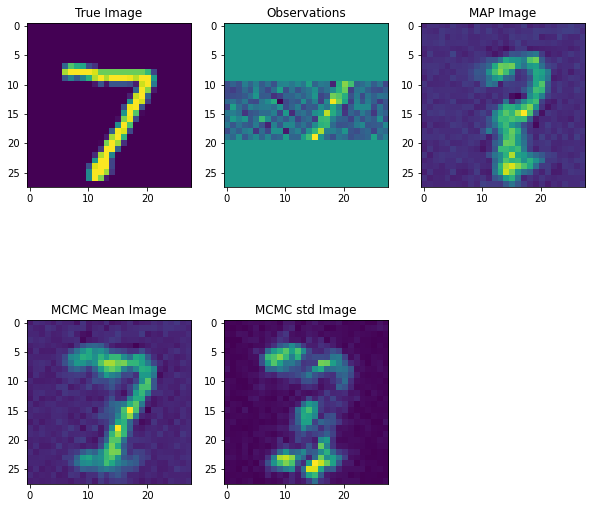

In [ ]:
test_image = test_dataset[0][0]
obs_idx = (range(10,20), range(10,20))
obs_operator = lambda x: observation_operator(x, obs_idx)

test_observations = obs_operator(test_image)
noise_mean = 0.
noise_std = 0.5

noise = torch.distributions.Normal(
        noise_mean,
        noise_std
        ).sample_n(len(test_observations.flatten()))
test_observations += noise.view(test_observations.shape)
test_observations = test_observations.to(device)

posterior_params = {
    'generator': generator,
    'obs_operator': obs_operator,
    'observations': test_observations,
    'prior_mean': torch.zeros(latent_dim, device=device),
    'prior_std': torch.ones(latent_dim, device=device),
    'noise_mean': noise_mean,
    'noise_std': noise_std
    }
  
HMC_params = {
    'num_samples': 100,
    'step_size': 1.,
    'num_steps_per_sample': 5,
    'burn': 50,
    'integrator': hamiltorch.Integrator.IMPLICIT,
    'sampler': hamiltorch.Sampler.HMC_NUTS,
    'desired_accept_rate': 0.3
    }

posterior = lambda z: latent_posterior(z, **posterior_params)

z = torch.randn(1, latent_dim, requires_grad=True, device=device)
z_MAP = compute_MAP(
    z=z, 
    num_iters=100,
    posterior=posterior
    )

z_MCMC = hamiltonian_MC(
    z_init=z_MAP.squeeze(0),
    posterior=posterior,
    HMC_params=HMC_params)

gen_MAP = generator(z_MAP)[0].detach().cpu()

gen_MCMC = generator(z_MCMC).detach().cpu()
gen_MCMC_mean = gen_MCMC.mean(dim=0)
gen_MCMC_std = gen_MCMC.std(dim=0)

obs_plot = torch.zeros(test_image.shape)
obs_plot[:, obs_idx] = test_observations.detach().cpu()

plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(test_image[0].detach().cpu())
plt.title('True Image')
plt.subplot(2,3,2)
plt.imshow(obs_plot[0].detach().cpu())
plt.title('Observations')
plt.subplot(2,3,3)
plt.imshow(gen_MAP[0])
plt.title('MAP Image')
plt.subplot(2,3,4)
plt.imshow(gen_MCMC_mean[0])
plt.title('MCMC Mean Image')
plt.subplot(2,3,5)
plt.imshow(gen_MCMC_std[0])
plt.title('MCMC std Image')
plt.show()

In [ ]:
gen_MCMC.shape

torch.Size([1, 28, 28])